In [1]:
import mmdet
from mmdet.apis import init_detector, inference_detector
import os
import cv2 as cv
import mmcv
import numpy as np
import PIL

In [47]:
mmdet_base_path = os.path.dirname(os.path.dirname(mmdet.__file__))
mmdet_config_path = os.path.join(mmdet_base_path, "configs")
mmdet_model_path = os.path.join(mmdet_base_path, "checkpoints")
print(mmdet_base_path, mmdet_config_path, mmdet_model_path, sep="\n")

/data/modules/mmdetection
/data/modules/mmdetection/configs
/data/modules/mmdetection/checkpoints


In [48]:
# config_file = 'faster_rcnn_r50_fpn_1x.py'
# checkpoint_file = 'faster_rcnn_r50_fpn_1x_20181010-3d1b3351.pth'

# https://github.com/open-mmlab/mmdetection/tree/master/configs/htc
config_file = "htc/htc_dconv_c3-c5_mstrain_400_1400_x101_64x4d_fpn_20e.py"
checkpoint_file = "htc_dconv_c3-c5_mstrain_400_1400_x101_64x4d_fpn_20e_20190408-0e50669c.pth"

video_path = "/data/aicity/train/2.mp4"

config_path = os.path.join(mmdet_config_path, config_file)
model_path = os.path.join(mmdet_model_path, checkpoint_file)
print(config_path, model_path, sep="\n")

/data/modules/mmdetection/configs/htc/htc_dconv_c3-c5_mstrain_400_1400_x101_64x4d_fpn_20e.py
/data/modules/mmdetection/checkpoints/htc_dconv_c3-c5_mstrain_400_1400_x101_64x4d_fpn_20e_20190408-0e50669c.pth


In [4]:
def load_video(filename):
    # Loads a video with opencv, returns PIL Images for each frame
    
    vid = cv.VideoCapture(filename)

    while vid.isOpened():
        has_frame, img = vid.read()

        if has_frame:
            yield img
        else:
            break
            
    vid.release()

In [38]:
class Detector:
    """
    built using: https://github.com/open-mmlab/mmdetection/tree/master/configs/htc
    (HTC + DCN + ResNeXt-101-FPN, mAP=50.7 model)
    
    Might take some fiddling to make it work with any mmdetection model
    
    config_file: "htc/htc_dconv_c3-c5_mstrain_400_1400_x101_64x4d_fpn_20e.py"
    checkpoint_file: "htc_dconv_c3-c5_mstrain_400_1400_x101_64x4d_fpn_20e_20190408-0e50669c.pth"
    
    
    """
    
    def __init__(self, config_path, model_path):
        self.model = init_detector(config_path, model_path, device='cuda:0')
        self.class_labels = self.model.CLASSES
        
    def detect_objects(self, img):
        results, segment = inference_detector(self.model, img) # I think they are segmentations, not sure though

        bbox_and_scores = np.vstack(results)
        bboxes, scores = bbox_and_scores[:, :4], bbox_and_scores[:, 4]
        labels = np.concatenate([[i] * len(bbox) for i, bbox in enumerate(results)])

        return bboxes, labels, scores
    
    def label_image(self, img, bboxes, labels, scores, score_thresh=0.1):
        def get_class_color(cls):
            return (0, 0, 255) # todo
        
        img = np.copy(img)
        
        for (x1, y1, x2, y2), cls, score in zip(bboxes, labels, scores):
            if score < score_thresh:
                continue
            
            col = get_class_color(cls)
            cv.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), col, 1) # draw boxes
            
        return img
        

In [25]:
vid = load_video(video_path)
img = next(vid)

In [39]:
detector = Detector(config_path, model_path)

/data/modules/mmdetection/mmdet/apis/inference.py:39: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


In [45]:
boxes, classes, scores = detector.detect_objects(img)
img_labelled = detector.label_image(img, boxes, classes, scores, score_thresh=0.1)

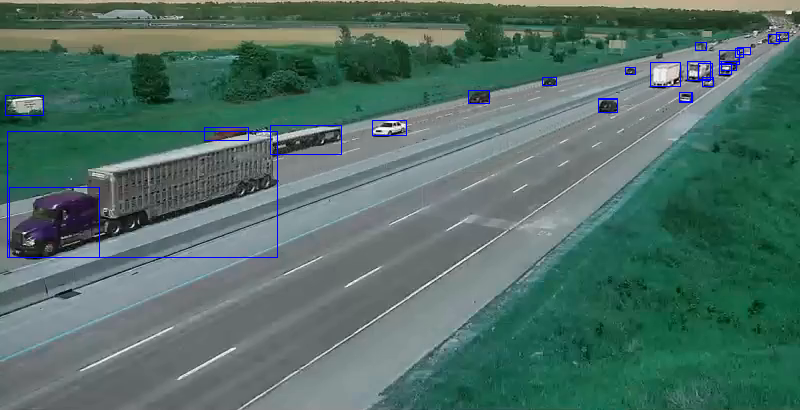

In [46]:
PIL.Image.fromarray(img_labelled)